<p style="font-size: 20px; margin-bottom: 3px; margin-top: 3px;">By: Ayushman Anupam</p>  
<p style="font-size: 20px; margin-top: 3px;">GitHub Link: <a href="https://github.com/AyushmanGHub">https://github.com/AyushmanGHub</a></p>

<div style="text-align: center;">
  <span style="color: #4A90E2; font-size: 40px; font-weight: bold;">CreditRisk - Predicting Borrower Reliability</span>
  <hr style="border: 1px dashed grey; width: 80%;"/>
</div>


<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:35px; font-weight: bold;">Importing needed Libraries</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from IPython.display import display

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.inspection import permutation_importance

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:35px; font-weight: bold;">Importing Dataset and Preprocessing</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>


In [2]:
# DataSource - https://www.kaggle.com/datasets/pradip11/amexpert-codelab-2021
df = pd.read_csv(r"Dataset.csv")

In [3]:
df.isnull().sum().sort_values(ascending=False)

no_of_children             774
owns_car                   547
no_of_days_employed        463
yearly_debt_payments        95
migrant_worker              87
total_family_members        83
credit_score                 8
customer_id                  0
default_in_last_6months      0
prev_defaults                0
credit_limit_used(%)         0
credit_limit                 0
occupation_type              0
name                         0
net_yearly_income            0
owns_house                   0
gender                       0
age                          0
credit_card_default          0
dtype: int64

In [4]:
df_filtered = df.dropna()
df_filtered = df_filtered[df_filtered["gender"] != "XNA"]
rows_with_missing_values = df[df.isnull().any(axis=1)].shape[0]

print(f"Total number of rows with missing values: {rows_with_missing_values + 1}")
print(f"Shape of original DataFrame: {df.shape}")
print(f"Shape of filtered DataFrame: {df_filtered.shape}")


Total number of rows with missing values: 2020
Shape of original DataFrame: (45528, 19)
Shape of filtered DataFrame: (43508, 19)


In [5]:
df_filtered.isnull().sum()

customer_id                0
name                       0
age                        0
gender                     0
owns_car                   0
owns_house                 0
no_of_children             0
net_yearly_income          0
no_of_days_employed        0
occupation_type            0
total_family_members       0
migrant_worker             0
yearly_debt_payments       0
credit_limit               0
credit_limit_used(%)       0
credit_score               0
prev_defaults              0
default_in_last_6months    0
credit_card_default        0
dtype: int64

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:35px; font-weight: bold;">Exploratory Data Analysis</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>


In [6]:
categorical_features = [col for col in df.columns if df[col].dtypes == "object"]
numerical_features =  [col for col in df.columns if df[col].dtypes != "object"]

print("no of categorial features: ", len(categorical_features))
print("Categorical features are", categorical_features)
print("no of Numerical features: ", len(numerical_features))
print("Numerical features are", numerical_features)

no of categorial features:  6
Categorical features are ['customer_id', 'name', 'gender', 'owns_car', 'owns_house', 'occupation_type']
no of Numerical features:  13
Numerical features are ['age', 'no_of_children', 'net_yearly_income', 'no_of_days_employed', 'total_family_members', 'migrant_worker', 'yearly_debt_payments', 'credit_limit', 'credit_limit_used(%)', 'credit_score', 'prev_defaults', 'default_in_last_6months', 'credit_card_default']


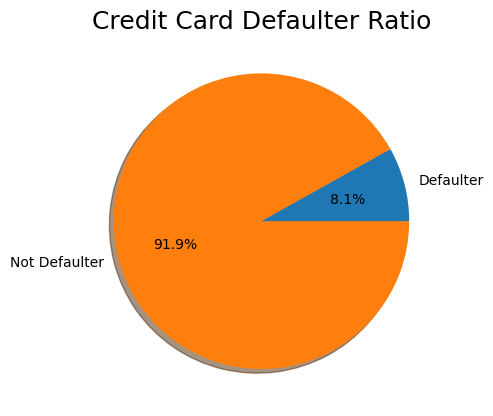

In [7]:
total_default_values = df_filtered.credit_card_default.value_counts(ascending=True).values

plt.figure()
plt.pie(total_default_values, labels=['Defaulter', 'Not Defaulter'], autopct='%1.1f%%', shadow=True)
plt.title('Credit Card Defaulter Ratio', fontsize=18)
plt.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:35px; font-weight: bold;">Data Encoding, Splitting and Normalization</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [8]:
df_filtered['owns_car'] = df_filtered['owns_car'].map({'Y': 1, 'N': 0})
df_filtered['owns_house'] = df_filtered['owns_house'].map({'Y': 1, 'N': 0})
df_filtered['gender'] = df_filtered['gender'].map({'M': 1, 'F': 0})
df_filtered['occupation_type'] = df_filtered['occupation_type'].astype('category').cat.codes

In [9]:
X = df_filtered.drop(columns=['credit_card_default', 'customer_id', 'name'])
y = df_filtered['credit_card_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)

<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">01. XGBoost Classifier</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [10]:
xgb_model = xgb.XGBClassifier(random_state=2, max_depth = 5, eval_metric='mlogloss',eta = 0.01,enable_categorical = True)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.01, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [72]:
feature_importance_dict = xgb_model.get_booster().get_score(importance_type='weight')
all_features = X_train.columns

# Ensure all features are included in the importance dictionary, even if not used (set to 0 if not used)
for feature in all_features:
    if feature not in feature_importance_dict:
        feature_importance_dict[feature] = 0
xgb_model_feature_importance = list(feature_importance_dict.values())
xgb_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns if isinstance(X_train, pd.DataFrame) else [f"Feature_{i}" for i in range(X_train.shape[1])],  # Feature names
    'xgb_model_feature_significance': xgb_model_feature_importance 
})
xgb_model_feature_significance_sorted = xgb_model_feature_significance.sort_values(by='xgb_model_feature_significance', ascending=False)
xgb_model_feature_significance

,Feature,xgb_model_feature_significance
0,age,26.0
1,gender,58.0
2,owns_car,18.0
3,owns_house,100.0
4,no_of_children,14.0
5,net_yearly_income,5.0
6,no_of_days_employed,75.0
7,occupation_type,3.0
8,total_family_members,101.0
9,migrant_worker,200.0


C:\Users\ayush\AppData\Local\Temp\ipykernel_9080\2699847496.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='xgb_model_feature_significance', y='Feature', data=xgb_model_feature_significance_sorted, ax=ax, palette='viridis')


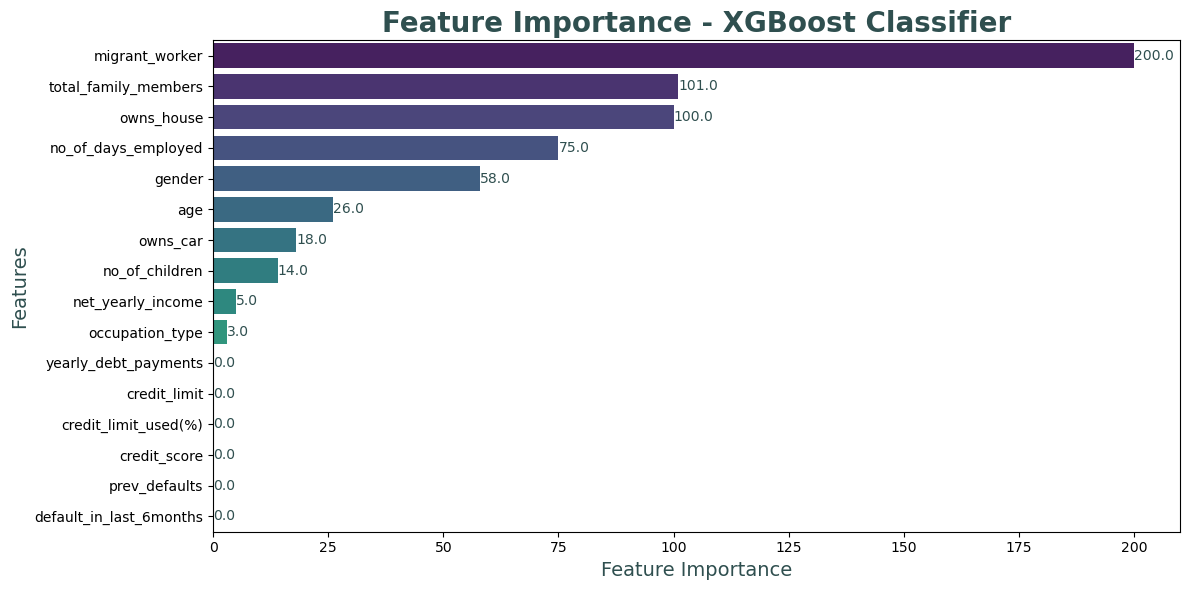

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='xgb_model_feature_significance', y='Feature', data=xgb_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(xgb_model_feature_significance_sorted['xgb_model_feature_significance']):
    ax.text(value, index, f'{value:.1f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance - XGBoost Classifier", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')

plt.tight_layout()

xgb_model_feature_significance = plt
xgb_model_feature_significance.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [13]:
xgb_model_y_pred = xgb_model.predict(X_test)
xgb_model_accuracy = accuracy_score(y_test, xgb_model_y_pred)
xgb_model_conf_matrix = confusion_matrix(y_test, xgb_model_y_pred)
xgb_model_class_report = classification_report(y_test, xgb_model_y_pred)

print(f"Accuracy: {xgb_model_accuracy:.4f}")
print("Confusion Matrix:")
print(xgb_model_conf_matrix)
print("Classification Report:")
print(xgb_model_class_report)

Accuracy: 0.9790
Confusion Matrix:
[[7963    0]
 [ 183  556]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7963
           1       1.00      0.75      0.86       739

    accuracy                           0.98      8702
   macro avg       0.99      0.88      0.92      8702
weighted avg       0.98      0.98      0.98      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">02. LightGBM Classifier</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [14]:
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 2792, number of negative: 32014
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1445
[LightGBM] [Info] Number of data points in the train set: 34806, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080216 -> initscore=-2.439415
[LightGBM] [Info] Start training from score -2.439415


c:\Users\ayush\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ayush\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\ayush\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ayush\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\ayush\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

LGBMClassifier(random_state=42)

In [70]:
lgb_model_feature_importance = lgb_model.booster_.feature_importance(importance_type='split')

lgb_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns if isinstance(X_train, pd.DataFrame) else [f"Feature_{i}" for i in range(X_train.shape[1])],  # Correct way to get feature names
    'lgb_model_feature_significance':lgb_model_feature_importance
})
lgb_model_feature_significance_sorted = lgb_model_feature_significance.sort_values(by='lgb_model_feature_significance', ascending=False)
lgb_model_feature_significance

,Feature,lgb_model_feature_significance
0,age,242
1,gender,45
2,owns_car,30
3,owns_house,24
4,no_of_children,31
5,net_yearly_income,367
6,no_of_days_employed,401
7,occupation_type,147
8,total_family_members,72
9,migrant_worker,13


C:\Users\ayush\AppData\Local\Temp\ipykernel_9080\3242021935.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='lgb_model_feature_significance', y='Feature', data=lgb_model_feature_significance_sorted, ax=ax, palette='viridis')


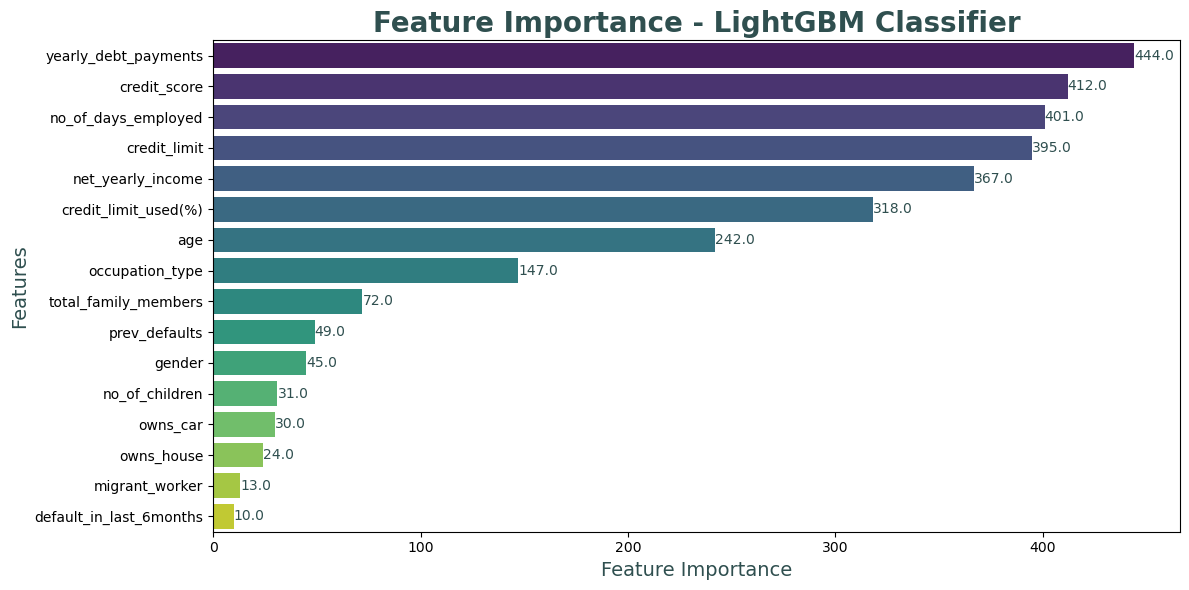

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='lgb_model_feature_significance', y='Feature', data=lgb_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(lgb_model_feature_significance_sorted['lgb_model_feature_significance']):
    ax.text(value, index, f'{value:.1f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance - LightGBM Classifier", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')

plt.tight_layout()

lgb_model_feature_significance = plt
lgb_model_feature_significance.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [17]:
lgb_model_y_pred = lgb_model.predict(X_test)

lgb_model_accuracy = accuracy_score(y_test, lgb_model_y_pred)
lgb_model_conf_matrix = confusion_matrix(y_test, lgb_model_y_pred)
lgb_model_class_report = classification_report(y_test, lgb_model_y_pred)

print(f"Accuracy: {lgb_model_accuracy:.4f}")
print("Confusion Matrix:")
print(lgb_model_conf_matrix)
print("Classification Report:")
print(lgb_model_class_report)

Accuracy: 0.9777
Confusion Matrix:
[[7926   37]
 [ 157  582]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7963
           1       0.94      0.79      0.86       739

    accuracy                           0.98      8702
   macro avg       0.96      0.89      0.92      8702
weighted avg       0.98      0.98      0.98      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">03. CatBoost Classifier</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [18]:
catboost_model = CatBoostClassifier(iterations=500, depth=5, learning_rate=0.1, random_seed=42, verbose=100)
catboost_model.fit(X_train, y_train)

0:	learn: 0.4365210	total: 175ms	remaining: 1m 27s
100:	learn: 0.0344304	total: 1.15s	remaining: 4.55s
200:	learn: 0.0299029	total: 2.07s	remaining: 3.08s
300:	learn: 0.0263682	total: 2.97s	remaining: 1.97s
400:	learn: 0.0230270	total: 4.03s	remaining: 995ms
499:	learn: 0.0202335	total: 5.09s	remaining: 0us


In [19]:
catboost_model_feature_importance = catboost_model.get_feature_importance()

# Get the feature names (assuming you have a DataFrame `X_train` with column names)
catboost_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns,  # Feature names from the training data
    'catboost_model_feature_significance': catboost_model_feature_importance  # Feature importance values
})
catboost_model_feature_significance_sorted = catboost_model_feature_significance.sort_values(by='catboost_model_feature_significance', ascending=False)
catboost_model_feature_significance

,Feature,catboost_model_feature_significance
0,age,2.557867
1,gender,0.803065
2,owns_car,0.682686
3,owns_house,0.183570
4,no_of_children,0.393430
5,net_yearly_income,2.673521
6,no_of_days_employed,4.587031
7,occupation_type,2.063236
8,total_family_members,1.222438
9,migrant_worker,0.162315


C:\Users\ayush\AppData\Local\Temp\ipykernel_9080\3853322135.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='catboost_model_feature_significance', y='Feature', data=catboost_model_feature_significance_sorted, ax=ax, palette='viridis')


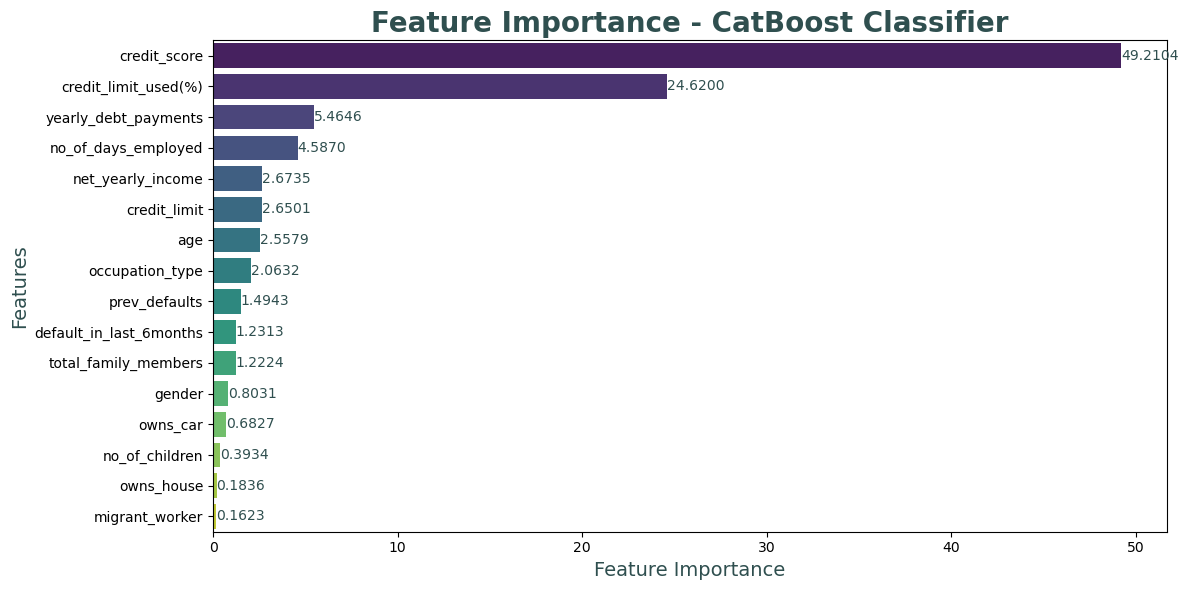

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='catboost_model_feature_significance', y='Feature', data=catboost_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(catboost_model_feature_significance_sorted['catboost_model_feature_significance']):
    ax.text(value, index, f'{value:.4f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance - CatBoost Classifier", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

catboost_model_feature_significance_plot = plt
catboost_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [21]:
catboost_model_y_pred = catboost_model.predict(X_test)

catboost_model_accuracy = accuracy_score(y_test, catboost_model_y_pred)
catboost_model_conf_matrix = confusion_matrix(y_test, catboost_model_y_pred)
catboost_model_class_report = classification_report(y_test, catboost_model_y_pred)

print(f"Accuracy: {catboost_model_accuracy:.4f}")
print("Confusion Matrix:")
print(catboost_model_conf_matrix)
print("Classification Report:")
print(catboost_model_class_report)

Accuracy: 0.9779
Confusion Matrix:
[[7929   34]
 [ 158  581]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7963
           1       0.94      0.79      0.86       739

    accuracy                           0.98      8702
   macro avg       0.96      0.89      0.92      8702
weighted avg       0.98      0.98      0.98      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">04. Decision Tree Classifier</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [22]:
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

In [23]:
dt_model_feature_importance = dt_model.feature_importances_

# Get the feature names (assuming you have a DataFrame `X_train` with column names)
dt_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns,  # Feature names from the training data
    'dt_model_feature_significance': dt_model_feature_importance  # Feature importance values
})
dt_model_feature_significance_sorted = dt_model_feature_significance.sort_values(by='dt_model_feature_significance', ascending=False)
dt_model_feature_significance

,Feature,dt_model_feature_significance
0,age,0.000000
1,gender,0.001483
2,owns_car,0.000000
3,owns_house,0.000000
4,no_of_children,0.000000
5,net_yearly_income,0.000367
6,no_of_days_employed,0.007732
7,occupation_type,0.000000
8,total_family_members,0.000000
9,migrant_worker,0.000000


C:\Users\ayush\AppData\Local\Temp\ipykernel_9080\3859504738.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='dt_model_feature_significance', y='Feature', data=dt_model_feature_significance_sorted, ax=ax, palette='viridis')


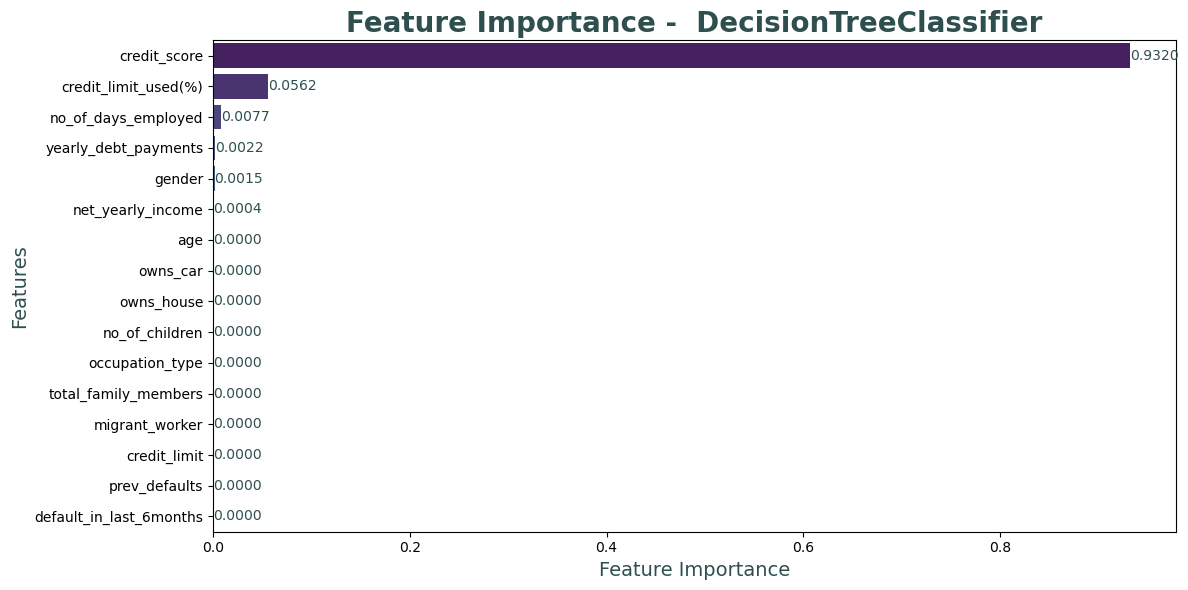

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='dt_model_feature_significance', y='Feature', data=dt_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(dt_model_feature_significance_sorted['dt_model_feature_significance']):
    ax.text(value, index, f'{value:.4f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance -  DecisionTreeClassifier", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

dt_model_feature_significance_plot = plt
dt_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [25]:
dt_model_y_pred = dt_model.predict(X_test)

dt_model_accuracy = accuracy_score(y_test, dt_model_y_pred)
dt_model_conf_matrix = confusion_matrix(y_test, dt_model_y_pred)
dt_model_class_report = classification_report(y_test, dt_model_y_pred)

print(f"Accuracy: {dt_model_accuracy:.4f}")
print("Confusion Matrix:")
print(dt_model_conf_matrix)
print("Classification Report:")
print(dt_model_class_report)

Accuracy: 0.9786
Confusion Matrix:
[[7960    3]
 [ 183  556]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7963
           1       0.99      0.75      0.86       739

    accuracy                           0.98      8702
   macro avg       0.99      0.88      0.92      8702
weighted avg       0.98      0.98      0.98      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">05. Random Forest Classifier</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [26]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [27]:
rf_model_feature_importance = rf_model.feature_importances_

rf_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns, 
    'rf_model_feature_significance': rf_model_feature_importance  
})
rf_model_feature_significance_sorted = rf_model_feature_significance.sort_values(by='rf_model_feature_significance', ascending=False)
rf_model_feature_significance

,Feature,rf_model_feature_significance
0,age,0.000302
1,gender,0.001057
2,owns_car,0.000151
3,owns_house,0.000012
4,no_of_children,0.000267
5,net_yearly_income,0.000946
6,no_of_days_employed,0.003573
7,occupation_type,0.000630
8,total_family_members,0.000273
9,migrant_worker,0.000083


C:\Users\ayush\AppData\Local\Temp\ipykernel_9080\2741119784.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rf_model_feature_significance', y='Feature', data=rf_model_feature_significance_sorted, ax=ax, palette='viridis')


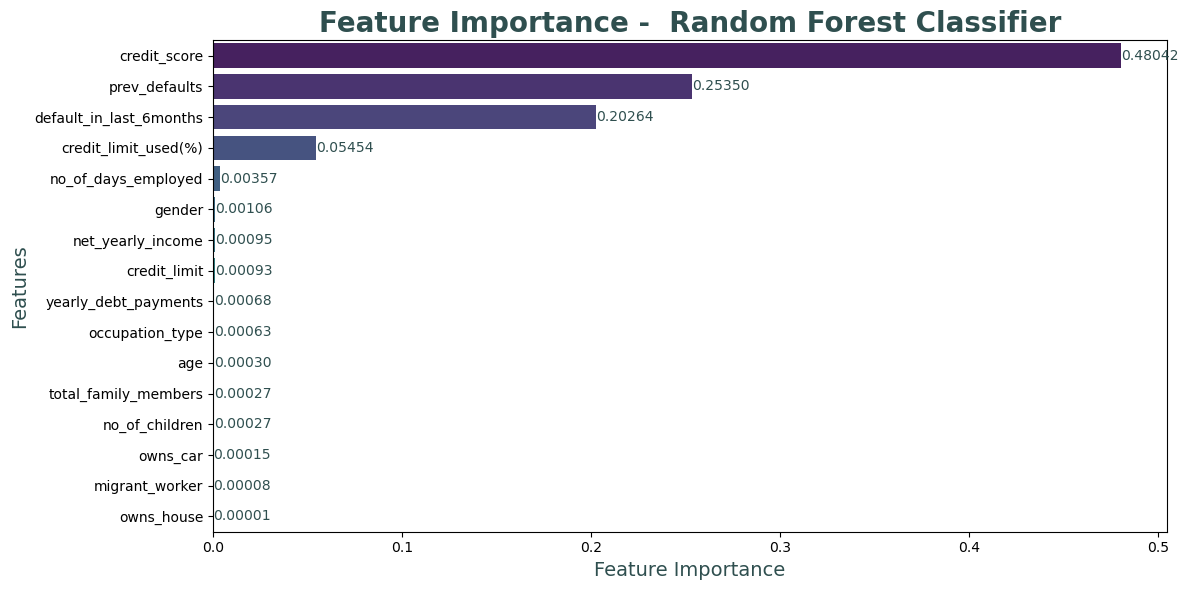

In [28]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='rf_model_feature_significance', y='Feature', data=rf_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(rf_model_feature_significance_sorted['rf_model_feature_significance']):
    ax.text(value, index, f'{value:.5f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance -  Random Forest Classifier", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

rf_model_feature_significance_plot = plt
rf_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [29]:
rf_model_y_pred = rf_model.predict(X_test)

rf_model_accuracy = accuracy_score(y_test, rf_model_y_pred)
rf_model_conf_matrix = confusion_matrix(y_test, rf_model_y_pred)
rf_model_class_report = classification_report(y_test, rf_model_y_pred)

print(f"Accuracy: {rf_model_accuracy:.4f}")
print("Confusion Matrix:")
print(rf_model_conf_matrix)
print("Classification Report:")
print(rf_model_class_report)

Accuracy: 0.9790
Confusion Matrix:
[[7963    0]
 [ 183  556]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7963
           1       1.00      0.75      0.86       739

    accuracy                           0.98      8702
   macro avg       0.99      0.88      0.92      8702
weighted avg       0.98      0.98      0.98      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">06. K-Neighbours Classifier</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [30]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [31]:
knn_model_feature_importance = permutation_importance(knn_model, X_train_scaled, y_train, n_repeats=10, random_state=42)
#(Above will take around 4 min and full CPU, be careful)
knn_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns, 
    'knn_model_feature_significance': knn_model_feature_importance.importances_mean 
})
knn_model_feature_significance_sorted = knn_model_feature_significance.sort_values(by='knn_model_feature_significance', ascending=False)
knn_model_feature_significance

,Feature,knn_model_feature_significance
0,age,0.002175
1,gender,0.002281
2,owns_car,0.001948
3,owns_house,0.001560
4,no_of_children,0.001307
5,net_yearly_income,-0.000060
6,no_of_days_employed,0.000661
7,occupation_type,0.002169
8,total_family_members,0.001540
9,migrant_worker,0.001201


C:\Users\ayush\AppData\Local\Temp\ipykernel_9080\168890697.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='knn_model_feature_significance', y='Feature', data=knn_model_feature_significance_sorted, ax=ax, palette='viridis')


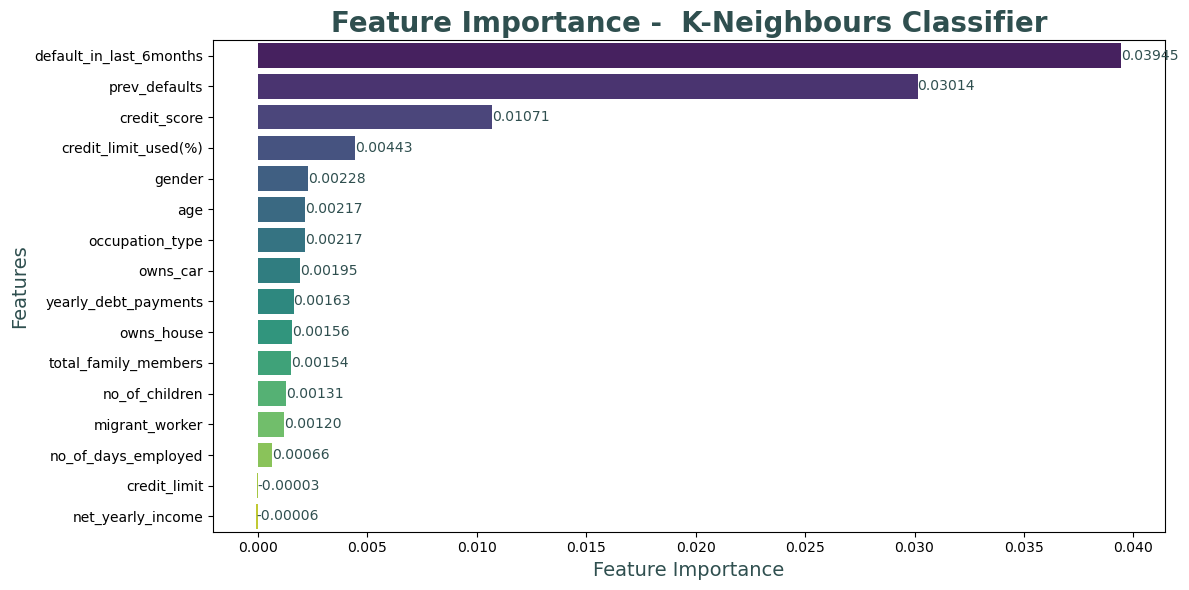

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='knn_model_feature_significance', y='Feature', data=knn_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(knn_model_feature_significance_sorted['knn_model_feature_significance']):
    ax.text(value, index, f'{value:.5f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance -  K-Neighbours Classifier", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

knn_model_feature_significance_plot = plt
knn_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [33]:
knn_model_y_pred = knn_model.predict(X_test_scaled)

knn_model_accuracy = accuracy_score(y_test, knn_model_y_pred)
knn_model_conf_matrix = confusion_matrix(y_test, knn_model_y_pred)
knn_model_class_report = classification_report(y_test, knn_model_y_pred)

print(f"Accuracy: {knn_model_accuracy:.4f}")
print("Confusion Matrix:")
print(knn_model_conf_matrix)
print("Classification Report:")
print(knn_model_class_report)

Accuracy: 0.9743
Confusion Matrix:
[[7938   25]
 [ 199  540]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7963
           1       0.96      0.73      0.83       739

    accuracy                           0.97      8702
   macro avg       0.97      0.86      0.91      8702
weighted avg       0.97      0.97      0.97      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">07. Support Vector Machine</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [34]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)

SVC(kernel='linear', random_state=42)

In [35]:
svm_model_coef = svm_model.coef_.flatten()  # Flatten to make it 1D if it's multi-class

# Create a DataFrame to hold the feature importance (absolute values of the coefficients)
svm_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns, 
    # 'svm_model_feature_significance': np.abs(svm_model_coef)  # Use absolute value of coefficients
    'svm_model_feature_significance': svm_model_coef
})
svm_model_feature_significance_sorted = svm_model_feature_significance.sort_values(by='svm_model_feature_significance', ascending=False)
svm_model_feature_significance

,Feature,svm_model_feature_significance
0,age,0.008700
1,gender,0.054169
2,owns_car,-0.024059
3,owns_house,-0.004039
4,no_of_children,0.057614
5,net_yearly_income,0.006837
6,no_of_days_employed,-0.045194
7,occupation_type,0.000436
8,total_family_members,-0.060211
9,migrant_worker,0.015521


C:\Users\ayush\AppData\Local\Temp\ipykernel_9080\3476562288.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='svm_model_feature_significance', y='Feature', data=svm_model_feature_significance_sorted, ax=ax, palette='viridis')


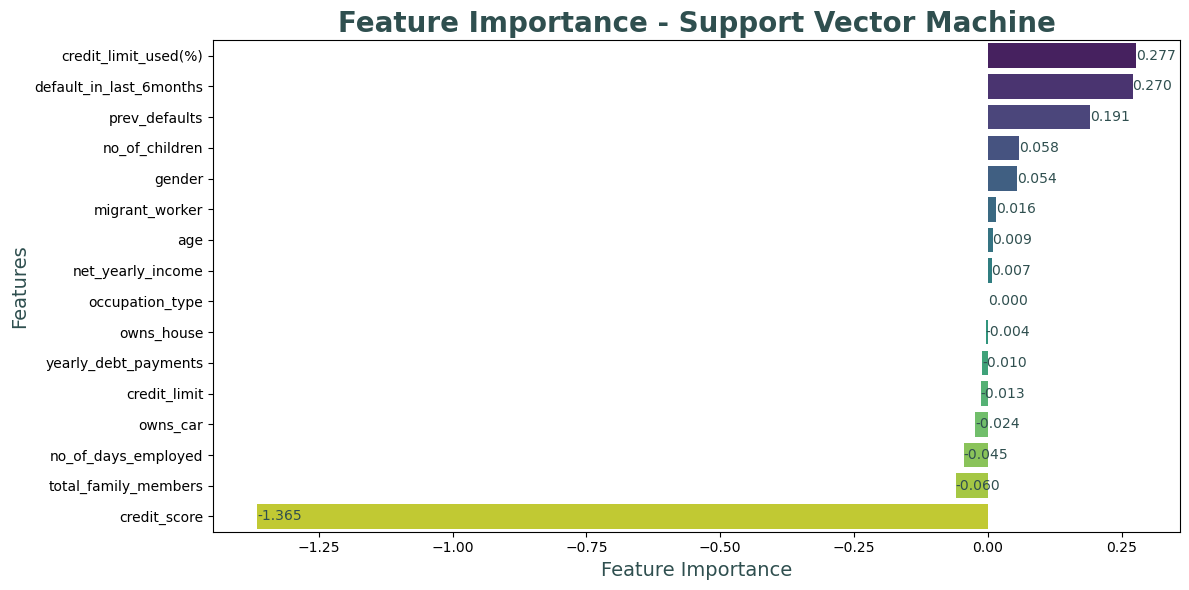

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='svm_model_feature_significance', y='Feature', data=svm_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(svm_model_feature_significance_sorted['svm_model_feature_significance']):
    ax.text(value, index, f'{value:.3f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance - Support Vector Machine", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

svm_model_feature_significance_plot = plt
svm_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [37]:
svm_model_y_pred = svm_model.predict(X_test_scaled)

svm_model_accuracy = accuracy_score(y_test, svm_model_y_pred)
svm_model_conf_matrix = confusion_matrix(y_test, svm_model_y_pred)
svm_model_class_report = classification_report(y_test, svm_model_y_pred)

print(f"Accuracy: {svm_model_accuracy:.4f}")
print("Confusion Matrix:")
print(svm_model_conf_matrix)
print("Classification Report:")
print(svm_model_class_report)

Accuracy: 0.9790
Confusion Matrix:
[[7963    0]
 [ 183  556]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7963
           1       1.00      0.75      0.86       739

    accuracy                           0.98      8702
   macro avg       0.99      0.88      0.92      8702
weighted avg       0.98      0.98      0.98      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">08. Adaptive Boosting Classifier</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [38]:
ada_model = AdaBoostClassifier(n_estimators=100, learning_rate = 0.01, random_state=22)
ada_model.fit(X_train, y_train)

c:\Users\ayush\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(learning_rate=0.01, n_estimators=100, random_state=22)

In [39]:
ada_model_feature_importance = ada_model.feature_importances_

ada_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns, 
    'ada_model_feature_significance': ada_model_feature_importance  
})
ada_model_feature_significance_sorted = ada_model_feature_significance.sort_values(by='ada_model_feature_significance', ascending=False)
ada_model_feature_significance

,Feature,ada_model_feature_significance
0,age,0.00
1,gender,0.00
2,owns_car,0.00
3,owns_house,0.00
4,no_of_children,0.00
5,net_yearly_income,0.00
6,no_of_days_employed,0.27
7,occupation_type,0.00
8,total_family_members,0.00
9,migrant_worker,0.00


C:\Users\ayush\AppData\Local\Temp\ipykernel_9080\1220884924.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ada_model_feature_significance', y='Feature', data=ada_model_feature_significance_sorted, ax=ax, palette='viridis')


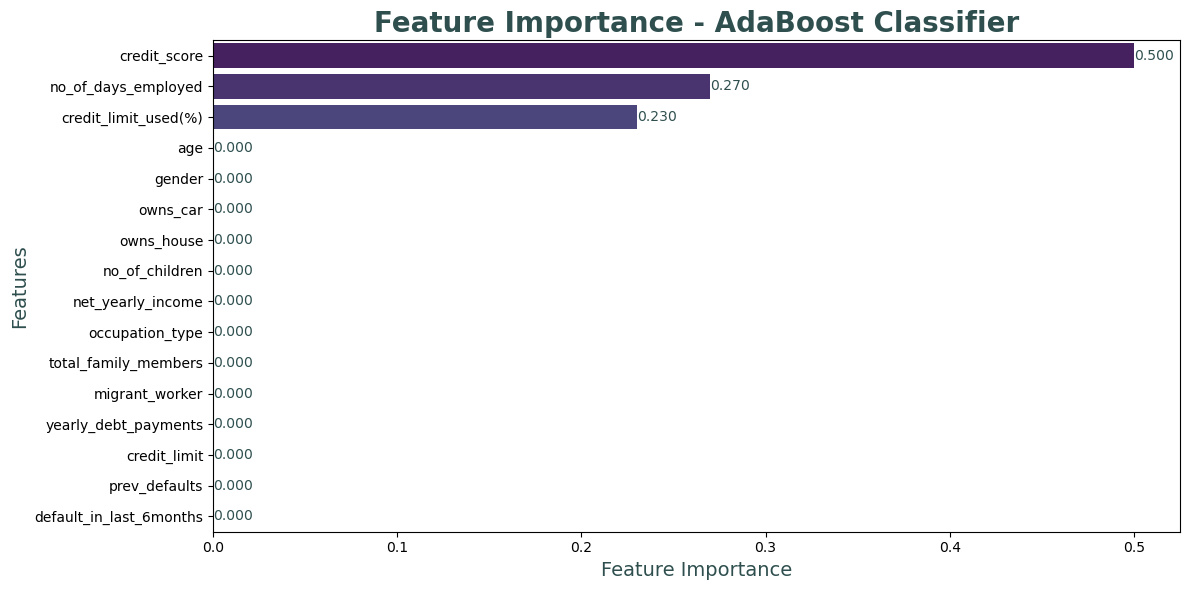

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='ada_model_feature_significance', y='Feature', data=ada_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(ada_model_feature_significance_sorted['ada_model_feature_significance']):
    ax.text(value, index, f'{value:.3f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance - AdaBoost Classifier", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

ada_model_feature_significance_plot = plt
ada_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div
>

In [41]:
ada_model_y_pred = ada_model.predict(X_test)

ada_model_accuracy = accuracy_score(y_test, ada_model_y_pred)
ada_model_conf_matrix = confusion_matrix(y_test, ada_model_y_pred)
ada_model_class_report = classification_report(y_test, ada_model_y_pred)

print(f"Accuracy: {ada_model_accuracy:.4f}")
print("Confusion Matrix:")
print(ada_model_conf_matrix)
print("Classification Report:")
print(ada_model_class_report)

Accuracy: 0.9790
Confusion Matrix:
[[7963    0]
 [ 183  556]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7963
           1       1.00      0.75      0.86       739

    accuracy                           0.98      8702
   macro avg       0.99      0.88      0.92      8702
weighted avg       0.98      0.98      0.98      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">09. Logistic Regression</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [42]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [43]:
logistic_model_coefficients = logistic_model.coef_[0]

logistic_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns, 
    'logistic_model_feature_significance': logistic_model_coefficients 
})
logistic_model_feature_significance_sorted = logistic_model_feature_significance.sort_values(by='logistic_model_feature_significance', ascending=False)
logistic_model_feature_significance

,Feature,logistic_model_feature_significance
0,age,0.040432
1,gender,0.264330
2,owns_car,-0.118501
3,owns_house,-0.001574
4,no_of_children,0.198384
5,net_yearly_income,-0.013438
6,no_of_days_employed,-0.250839
7,occupation_type,-0.049030
8,total_family_members,-0.231422
9,migrant_worker,0.054121


C:\Users\ayush\AppData\Local\Temp\ipykernel_9080\895998697.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='logistic_model_feature_significance', y='Feature', data=logistic_model_feature_significance_sorted, ax=ax, palette='viridis')


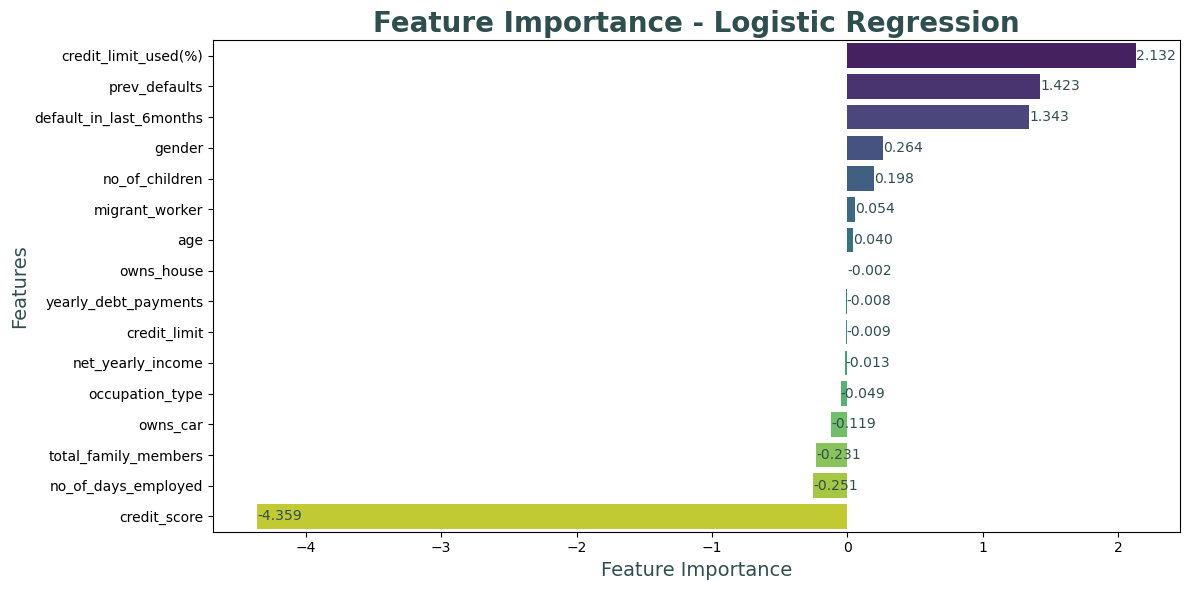

In [44]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='logistic_model_feature_significance', y='Feature', data=logistic_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(logistic_model_feature_significance_sorted['logistic_model_feature_significance']):
    ax.text(value, index, f'{value:.3f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance - Logistic Regression", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

logistic_model_feature_significance_plot = plt
logistic_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [45]:
# Predictions
logistic_model_y_pred = logistic_model.predict(X_test_scaled)

# Model Evaluation
logistic_model_accuracy = accuracy_score(y_test, logistic_model_y_pred)
print(f"Accuracy: {logistic_model_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, logistic_model_y_pred))

Accuracy: 0.9790
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7963
           1       0.97      0.78      0.86       739

    accuracy                           0.98      8702
   macro avg       0.97      0.89      0.93      8702
weighted avg       0.98      0.98      0.98      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">10. Gradient Boosting Classifier</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [46]:
gbm_model = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42)
gbm_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=500, random_state=42)

In [47]:
gbm_model_feature_importance = gbm_model.feature_importances_

gbm_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns, 
    'gbm_model_feature_significance': gbm_model_feature_importance  
})
gbm_model_feature_significance_sorted = gbm_model_feature_significance.sort_values(by='gbm_model_feature_significance', ascending=False)
gbm_model_feature_significance

,Feature,gbm_model_feature_significance
0,age,0.004384
1,gender,0.001637
2,owns_car,0.000497
3,owns_house,0.000557
4,no_of_children,0.000938
5,net_yearly_income,0.010689
6,no_of_days_employed,0.013213
7,occupation_type,0.003577
8,total_family_members,0.000979
9,migrant_worker,0.000507


C:\Users\ayush\AppData\Local\Temp\ipykernel_9080\954021199.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gbm_model_feature_significance', y='Feature', data=gbm_model_feature_significance_sorted, ax=ax, palette='viridis')


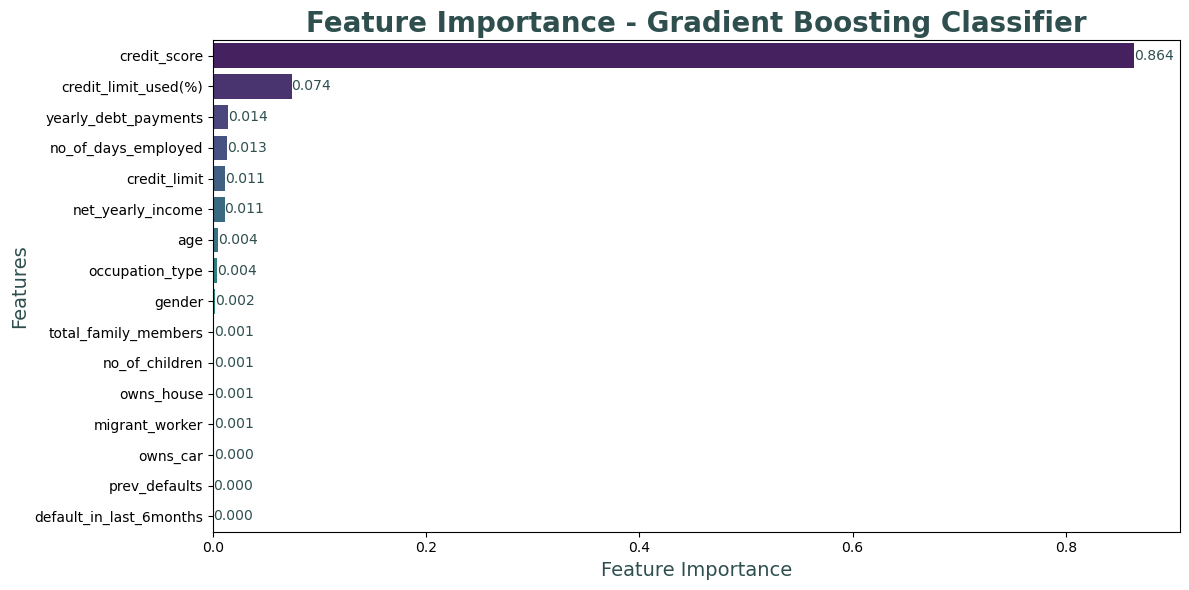

In [48]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='gbm_model_feature_significance', y='Feature', data=gbm_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(gbm_model_feature_significance_sorted['gbm_model_feature_significance']):
    ax.text(value, index, f'{value:.3f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance - Gradient Boosting Classifier", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

gbm_model_feature_significance_plot = plt
gbm_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [49]:
# Predictions
gbm_model_y_pred = gbm_model.predict(X_test)

# Model Evaluation
gbm_model_accuracy = accuracy_score(y_test, gbm_model_y_pred)
print(f"Accuracy: {gbm_model_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, gbm_model_y_pred))

Accuracy: 0.9760
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7963
           1       0.92      0.79      0.85       739

    accuracy                           0.98      8702
   macro avg       0.95      0.89      0.92      8702
weighted avg       0.98      0.98      0.98      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">11. Neural Networks (MLP Classifier)</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [50]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100,50), activation='relu', max_iter=500, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

In [51]:
mlp_model_feature_importance = permutation_importance(mlp_model, X_train_scaled, y_train, n_repeats=10, random_state=42)

mlp_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns, 
    'mlp_model_feature_significance': mlp_model_feature_importance.importances_mean
})
mlp_model_feature_significance_sorted = mlp_model_feature_significance.sort_values(by='mlp_model_feature_significance', ascending=False)
mlp_model_feature_significance

,Feature,mlp_model_feature_significance
0,age,0.014015
1,gender,0.010513
2,owns_car,0.010329
3,owns_house,0.009682
4,no_of_children,0.009349
5,net_yearly_income,0.004485
6,no_of_days_employed,0.006304
7,occupation_type,0.015262
8,total_family_members,0.012889
9,migrant_worker,0.007729


C:\Users\ayush\AppData\Local\Temp\ipykernel_9080\1129891281.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mlp_model_feature_significance', y='Feature', data=mlp_model_feature_significance_sorted, ax=ax, palette='viridis')


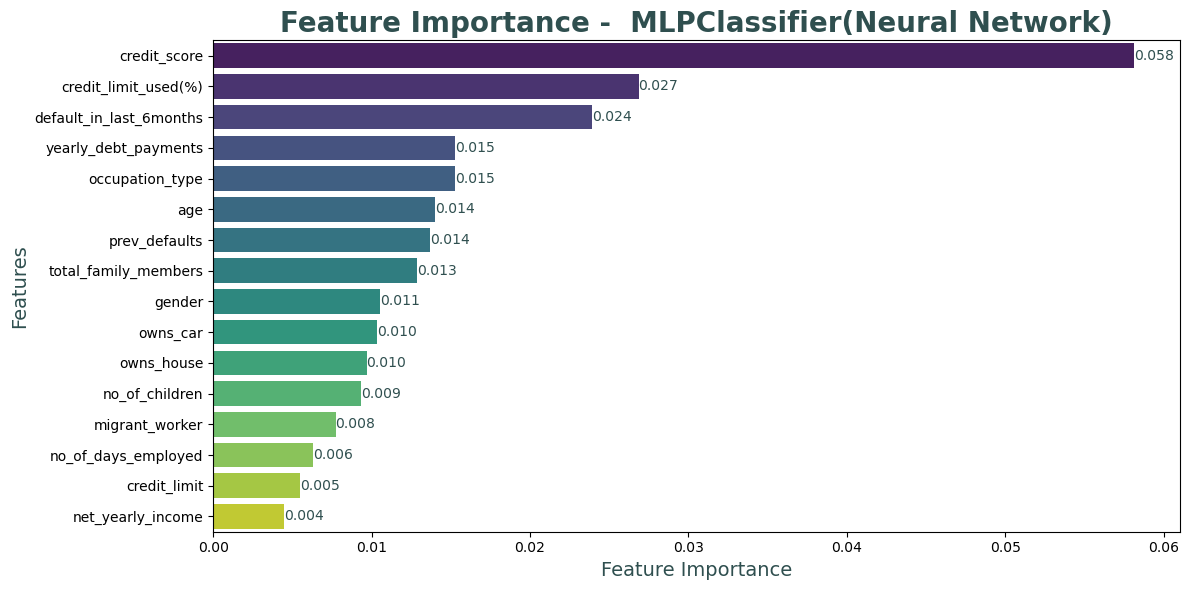

In [52]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='mlp_model_feature_significance', y='Feature', data=mlp_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(mlp_model_feature_significance_sorted['mlp_model_feature_significance']):
    ax.text(value, index, f'{value:.3f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance -  MLPClassifier(Neural Network)", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

mlp_model_feature_significance_plot = plt
mlp_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [53]:
# Predictions
mlp_model_y_pred = mlp_model.predict(X_test_scaled)

# Model Evaluation
mlp_model_accuracy = accuracy_score(y_test, mlp_model_y_pred)
print(f"Accuracy: {mlp_model_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, mlp_model_y_pred))

Accuracy: 0.9736
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7963
           1       0.86      0.82      0.84       739

    accuracy                           0.97      8702
   macro avg       0.92      0.91      0.91      8702
weighted avg       0.97      0.97      0.97      8702



<div style="text-align: center;">
  <span style="color: #FF0000; font-size:40px; font-weight: bold;">12. Extra Trees Classifier</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Model Training and Feature selection</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [54]:
et_model = ExtraTreesClassifier(n_estimators=500, max_depth=10, random_state=42)
et_model.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=10, n_estimators=500, random_state=42)

In [55]:
et_model_feature_importance = et_model.feature_importances_

et_model_feature_significance = pd.DataFrame({
    'Feature': X_train.columns, 
    'et_model_feature_significance': et_model_feature_importance  
})
et_model_feature_significance_sorted = et_model_feature_significance.sort_values(by='et_model_feature_significance', ascending=False)
et_model_feature_significance

,Feature,et_model_feature_significance
0,age,0.000350
1,gender,0.001661
2,owns_car,0.000498
3,owns_house,0.000227
4,no_of_children,0.000533
5,net_yearly_income,0.000455
6,no_of_days_employed,0.001508
7,occupation_type,0.000441
8,total_family_members,0.000495
9,migrant_worker,0.000392


C:\Users\ayush\AppData\Local\Temp\ipykernel_9080\2607057498.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='et_model_feature_significance', y='Feature', data=et_model_feature_significance_sorted, ax=ax, palette='viridis')


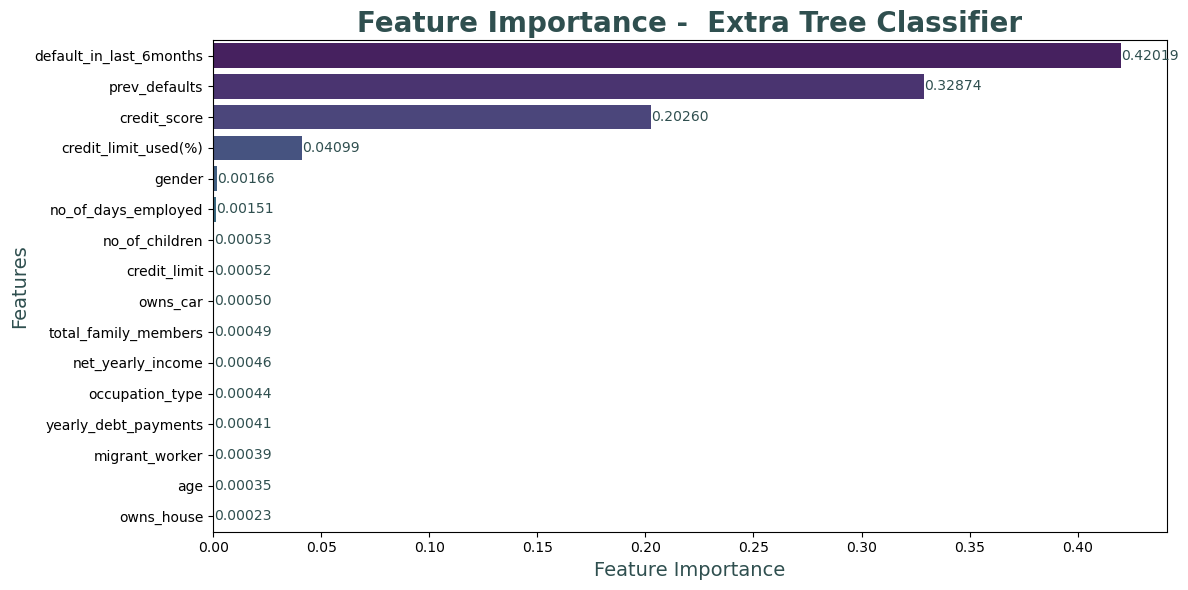

In [56]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='et_model_feature_significance', y='Feature', data=et_model_feature_significance_sorted, ax=ax, palette='viridis')

for index, value in enumerate(et_model_feature_significance_sorted['et_model_feature_significance']):
    ax.text(value, index, f'{value:.5f}', va='center', ha='left', fontsize=10, color='#2F4F4F')

ax.set_title("Feature Importance -  Extra Tree Classifier", fontsize=20, fontweight='bold', color='#2F4F4F')
ax.set_xlabel('Feature Importance', fontsize=14, color='#2F4F4F')
ax.set_ylabel('Features', fontsize=14, color='#2F4F4F')
plt.tight_layout()

et_model_feature_significance_plot = plt
et_model_feature_significance_plot.show()

<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:30px; font-weight: bold;">Prediction and Model Evaluation</span>
  <hr style="border: 2px solid grey; width: 60%;"/>
</div>

In [57]:
# Predictions
et_model_y_pred = et_model.predict(X_test)

# Model Evaluation
et_model_accuracy = accuracy_score(y_test, et_model_y_pred)
print(f"Accuracy: {et_model_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, et_model_y_pred))

Accuracy: 0.9790
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7963
           1       1.00      0.75      0.86       739

    accuracy                           0.98      8702
   macro avg       0.99      0.88      0.92      8702
weighted avg       0.98      0.98      0.98      8702



<div style="text-align: center;">
  <span style="color: #2E8B57; font-size:45px; font-weight: bold;">Feature Significance of Models</span>
  <hr style="border: 2px solid grey; width: 100%;"/>
</div>

In [58]:
models = {'Extra Tree Classifier':et_model, 
              'MLP Classifier (Neural Networks)':mlp_model, 
              'Gradient Boosting Classifier':gbm_model,
              'Logistic Regression':logistic_model,
              'Adaptive Boosting Classifier':ada_model, 
              'Support Vector Machine':svm_model, 
              'K-Neighbours Classifier':knn_model, 
              'Random Forest Classifier':rf_model, 
              'Decision Tree Classifier':dt_model,
              'CatBoost Classifier':catboost_model,
              'LightGBM Classifier':lgb_model, 
              'XGBoost Classifier':xgb_model}

In [74]:
Feature_significance = et_model_feature_significance.merge(mlp_model_feature_significance, on='Feature', how='outer') \
                                           .merge(gbm_model_feature_significance, on='Feature', how='outer') \
                                           .merge(logistic_model_feature_significance, on='Feature', how='outer') \
                                           .merge(ada_model_feature_significance, on='Feature', how='outer') \
                                           .merge(svm_model_feature_significance, on='Feature', how='outer') \
                                           .merge(knn_model_feature_significance, on='Feature', how='outer') \
                                           .merge(rf_model_feature_significance, on='Feature', how='outer') \
                                           .merge(dt_model_feature_significance, on='Feature', how='outer') \
                                           .merge(catboost_model_feature_significance, on='Feature', how='outer') \
                                           .merge(lgb_model_feature_significance, on='Feature', how='outer') \
                                           .merge(xgb_model_feature_significance, on='Feature', how='outer')
Feature_significance.columns = ['Features', 'Extra Tree Classifier', 'MLP Classifier (Neural Networks)', 'Gradient Boosting Classifier', 'Logistic Regression', 
     'Adaptive Boosting Classifier', 'Support Vector Machine', 'K-Neighbours Classifier', 'Random Forest Classifier', 'Decision Tree Classifier', 
    'CatBoost Classifier', 'LightGBM Classifier', 'XGBoost Classifier']

Feature_significance


,Features,Extra Tree Classifier,MLP Classifier (Neural Networks),Gradient Boosting Classifier,Logistic Regression,Adaptive Boosting Classifier,Support Vector Machine,K-Neighbours Classifier,Random Forest Classifier,Decision Tree Classifier,CatBoost Classifier,LightGBM Classifier,XGBoost Classifier
0,age,0.000350,0.014015,0.004384,0.040432,0.00,0.008700,0.002175,0.000302,0.000000,2.557867,242,26.0
1,credit_limit,0.000517,0.005479,0.011186,-0.008678,0.00,-0.013101,-0.000034,0.000928,0.000000,2.650134,395,0.0
2,credit_limit_used(%),0.040987,0.026857,0.073546,2.132470,0.23,0.276825,0.004427,0.054544,0.056196,24.620031,318,0.0
3,credit_score,0.202596,0.058128,0.863968,-4.359083,0.50,-1.365196,0.010714,0.480419,0.931974,49.210365,412,0.0
4,default_in_last_6months,0.420189,0.023892,0.000069,1.343448,0.00,0.270363,0.039450,0.202644,0.000000,1.231327,10,0.0
5,gender,0.001661,0.010513,0.001637,0.264330,0.00,0.054169,0.002281,0.001057,0.001483,0.803065,45,58.0
6,migrant_worker,0.000392,0.007729,0.000507,0.054121,0.00,0.015521,0.001201,0.000083,0.000000,0.162315,13,200.0
7,net_yearly_income,0.000455,0.004485,0.010689,-0.013438,0.00,0.006837,-0.000060,0.000946,0.000367,2.673521,367,5.0
8,no_of_children,0.000533,0.009349,0.000938,0.198384,0.00,0.057614,0.001307,0.000267,0.000000,0.393430,31,14.0
9,no_of_days_employed,0.001508,0.006304,0.013213,-0.250839,0.27,-0.045194,0.000661,0.003573,0.007732,4.587031,401,75.0


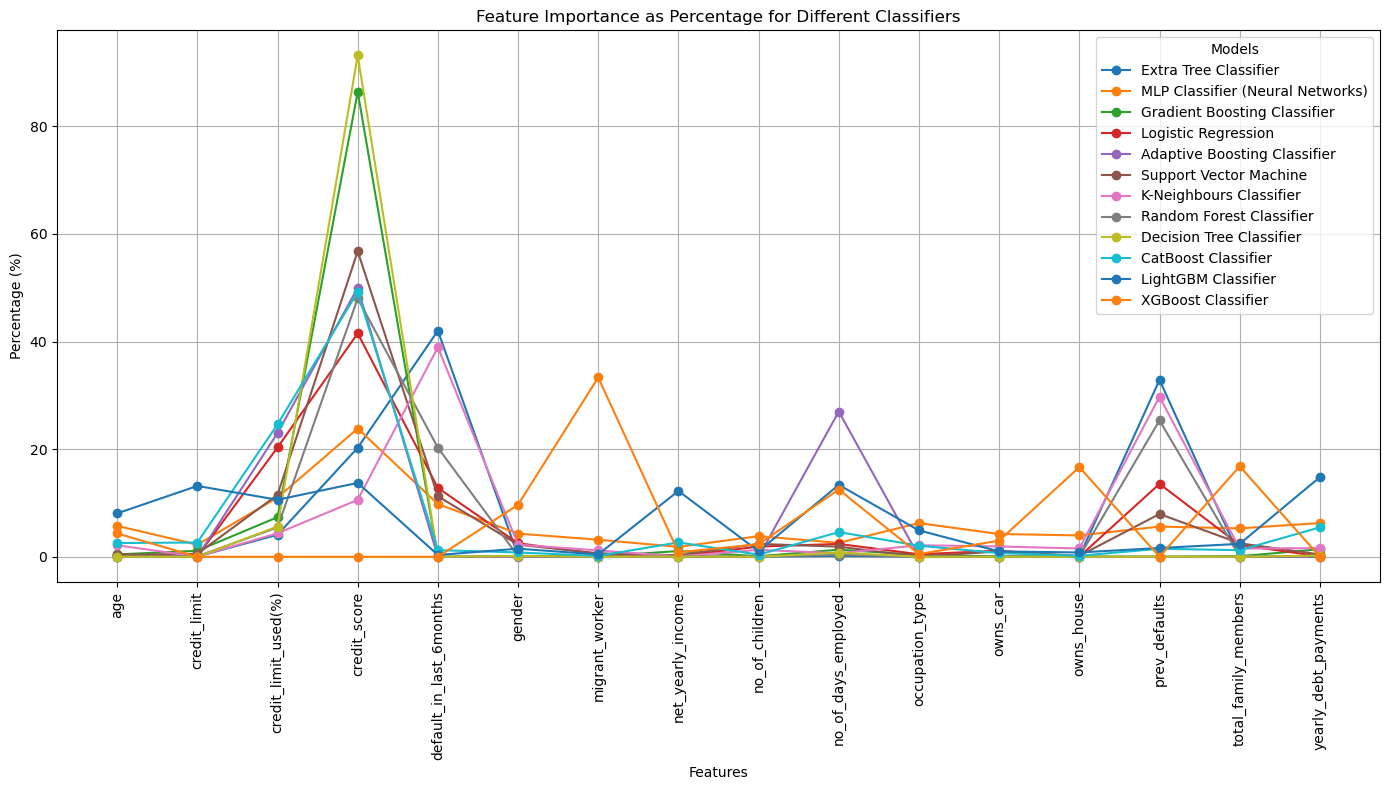

In [75]:
plt.figure(figsize=(14, 8))

for model in models:
    # Compute the sum of absolute values of feature importance for percentage
    sum_abs_value = sum(np.abs(Feature_significance[model]))
    percentage_data = (np.abs(np.array(Feature_significance[model])) / sum_abs_value) * 100
    plt.plot(Feature_significance["Features"], percentage_data, marker='o', label=model)

plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Percentage (%)')
plt.title('Feature Importance as Percentage for Different Classifiers')
plt.grid(True)
plt.tight_layout()
plt.legend(title="Models", loc='upper right', frameon=True)
plt.show()


In [78]:
sample_data = df_filtered.sample(n=20)

result_df = pd.DataFrame()
result_df['customer_id'] = sample_data['customer_id']
result_df['Actual Default'] = sample_data['credit_card_default']  

feature_columns = [col for col in df_filtered.columns if col not in ['credit_card_default', 'customer_id', 'name']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(sample_data[feature_columns])

for model_name, model in models.items():
    if model_name in ['K-Neighbours Classifier', 'Support Vector Machine', 'Logistic Regression', 'MLP Classifier (Neural Networks)']:
        predictions = model.predict(scaled_features)
    else:
        predictions = model.predict(sample_data[feature_columns])
    
    result_df[model_name] = predictions

def highlight_correctness(val, actual):
    """
    Color cells light blue if prediction matches actual default, light red otherwise.
    """
    if val == actual:
        return 'background-color: #ADD8E6; color: black; font-weight: bold; border: 1px solid black'  # Light Blue for Correct
    else:
        return 'background-color: #FFA07A; color: black; font-weight: bold; border: 1px solid black'  # Light Red for Incorrect

styled_df = result_df.style.apply(
    lambda x: [highlight_correctness(v, x['Actual Default']) if c in models else 'border: 1px solid black' for c, v in x.items()], 
    axis=1
)
styled_df = styled_df.set_caption("🔍 **Model Predictions for Credit Card Default**").set_table_styles([
    {'selector': 'caption', 'props': [('text-align', 'center'), ('font-size', '16px'), ('font-weight', 'bold')]},
    {'selector': 'th', 'props': [('border', '1px solid black'), ('background-color', '#f2f2f2'), ('font-weight', 'bold')]}
])

styled_df = styled_df.hide(axis="index")
display(styled_df)


customer_id,Actual Default,Extra Tree Classifier,MLP Classifier (Neural Networks),Gradient Boosting Classifier,Logistic Regression,Adaptive Boosting Classifier,Support Vector Machine,K-Neighbours Classifier,Random Forest Classifier,Decision Tree Classifier,CatBoost Classifier,LightGBM Classifier,XGBoost Classifier
CST_113216,0,0,0,0,0,0,0,0,0,0,0,0,0
CST_142172,0,0,0,0,0,0,0,0,0,0,0,0,0
CST_156692,0,0,0,0,0,0,0,0,0,0,0,0,0
CST_112786,0,0,0,0,0,0,0,0,0,0,0,0,0
CST_105831,1,1,1,1,1,1,1,0,1,1,1,1,1
CST_149177,0,0,0,0,0,0,0,0,0,0,0,0,0
CST_134385,0,0,0,0,0,0,0,0,0,0,0,0,0
CST_129172,0,0,0,0,0,0,0,0,0,0,0,0,0
CST_151563,1,0,0,1,0,0,0,0,0,0,0,1,0
CST_142936,0,0,0,0,0,0,0,0,0,0,0,0,0
